## Test Time Augmentation

After training our model on the provided images, we would like to generate predictions for the separate test set. Unfortunately, our test images are about 1200x310 and our model can only handle 256x256 inputs.

We can work around this by taking multiple slices of the image, running them through the model and then storing the predictions for each slice.

Some other thoughts:
- How far should we move the 256x256 input when making each set of predictions?
- Is there an intelligent way to average predictions from overlapping slices?
- How do we ensemble predictions from multiple models?

In [1]:
import os
import PIL
import math
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor, tensor

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as patheffects

from RetinaNet.inference import get_bounding_box_predictions_for_dataset, setupNewCrop, get_bounding_box_predictions
from RetinaNet.object_detection_helper import process_output, nms, rescale_boxes

import fastai
from fastai.core import is_tuple
from fastai.torch_core import to_np
from fastai.basic_train import _loss_func2activ, validate, progress_bar, loss_batch
from fastai.vision.data import pil2tensor
from fastai.vision import Path, open_image, ImageBBox, ObjectItemList, get_transforms, bb_pad_collate, conv_layer, Learner, create_body, models, conv2d, ifnone, DatasetType, range_of, progress_bar, ShowGraph, get_preds, Image, load_learner

In [2]:
#from RetinaNet.object_detection_helper import 
from RetinaNet.object_detection_helper import create_anchors, show_results_side_by_side, get_annotations_from_path
from RetinaNet.RetinaNetFocalLoss import FocalLoss
from RetinaNet.RetinaNet import RetinaNet
from RetinaNet.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [3]:
DATA = Path('data/')
IMAGES = DATA/'train_labelled_images'
TEST_IMAGES = DATA/'sorghum_test_public'
ANNOTATIONS = DATA/'train_labelled_annotations'

In [4]:
images, lbl_bbox = get_annotations_from_path(ANNOTATIONS, IMAGES)
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[IMAGES/o.name]

In [5]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(IMAGES)
    src = src.split_by_rand_pct(0.1)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(), size=size, tfm_y=True)
    return src.databunch(path=IMAGES, bs=16, collate_fn=bb_pad_collate)

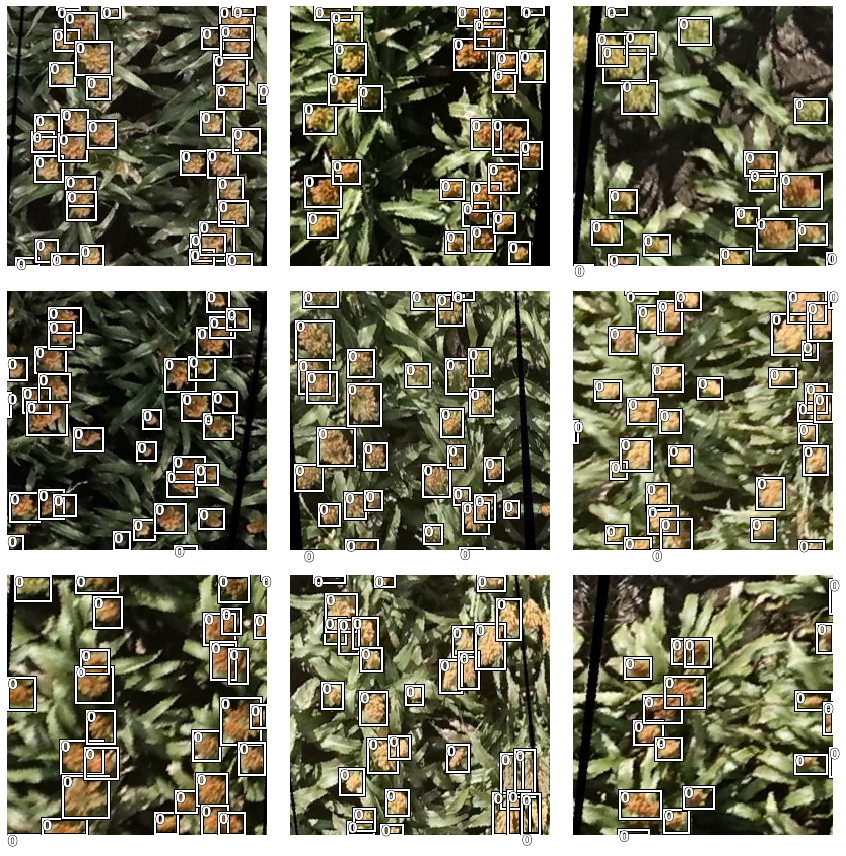

In [6]:
batch_size = 64
image_size = 256

data = get_data(batch_size, image_size)
data.show_batch(3)

In [7]:
#WARNING: Hardcoded anchor sizes probably not great for when we change things
ratios=[0.5, 1, 2]
scales=[0.35, 0.5, 1]
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4),(2,2)], ratios=ratios, scales=scales)

In [8]:
n_classes = data.train_ds.c

crit = FocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=9, sizes=[32,16,8,4,2], chs=32, final_bias=-4., n_conv=2)

In [9]:
voc = PascalVOCMetric(anchors, image_size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit)

In [10]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [11]:
learn.fit_one_cycle(20, 2e-3)

epoch,train_loss,valid_loss,time
0,2.769731,1.569266,00:07
1,2.063023,1.746176,00:05
2,1.700941,1.561077,00:05
3,1.464798,1.152530,00:05
4,1.296194,1.019616,00:04
5,1.168169,0.960080,00:04
6,1.060715,0.896983,00:05
7,0.974795,0.841720,00:05
8,0.902553,0.723906,00:05
9,0.847545,0.850937,00:05


In [12]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,time
0,0.602434,0.631023,00:05
1,0.596591,0.657531,00:04
2,0.592710,0.622960,00:05
3,0.586721,0.569745,00:04
4,0.584670,0.628207,00:05
5,0.581453,0.550323,00:05
6,0.570518,0.595968,00:05
7,0.558193,0.580657,00:04
8,0.550169,0.529849,00:05
9,0.536417,0.527586,00:05


## Get Bounding Boxes via Slicing

One approach to generate our bounding boxes for a full image is to take multiple crops of the image and stick them together. Unfortunately this can be very tricky as we have to keep track of many things:
 - Where are we currently cropping the image?
 - We need to make sure we don't crop too far outside of the image
 - Each image has a unique shape, so we have to keep track of it when cropping

In [13]:
#NOTE: MOVED TO INFERENCE.py
#NOTE: MOVED TO INFERENCE.py
#NOTE: MOVED TO INFERENCE.py

In [14]:
#Let's test this out on a single slice and plot the resulting bboxes on to our image
dl = learn.dl(DatasetType.Valid)

old_open_image = fastai.vision.data.open_image

i = 4
j = 1
original_images = list(dl.x)
setupNewCrop(i, j)

all_imgs, all_boxes, all_scores = get_bounding_box_predictions(learn, dl, anchors, original_images, i,j)

fastai.vision.data.open_image = old_open_image

torch.Size([998, 254])


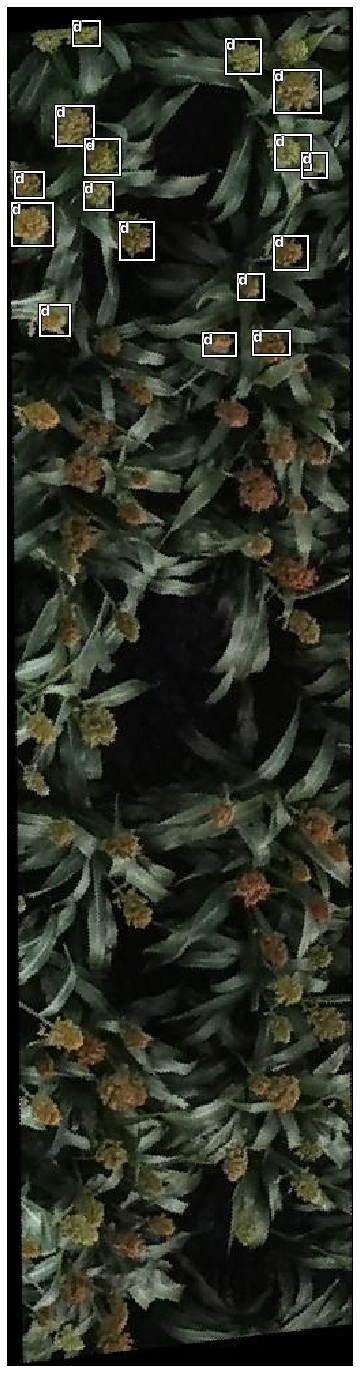

In [15]:
bboxes = all_boxes[0]
img = all_imgs[0]

classId = [0 for _ in range(len(bboxes))]
bbox = ImageBBox.create(*img.size, (bboxes), classId, classes=['d'])
print(img.size)
img.show(figsize=(25,25), y=bbox)

## Ensembling Predictions

Now that we've generated predictions for multiple areas of the image, we would like to combine the predictions somehow. The naive approach might be to simply concatenate all the bounding boxes into a single list but this won't work due to overlapping windows. Instead we'll have to ensemblem the predictions.

Fortunately this has already been implemented at: https://github.com/ahrnbom/ensemble-objdet

In [16]:
all_preds = list(get_bounding_box_predictions_for_dataset(learn, anchors))

print(len(all_preds))

30


In [17]:
#MOVED TO inference.py
#MOVED TO inference.py
#MOVED TO inference.py

torch.Size([998, 254])


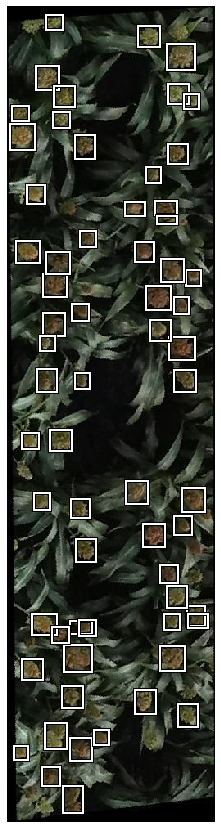

In [18]:
#all_preds[0] is a list of bounding boxes for an image in the shape [top, left, bottom, right, confidence]
#We need to remove confidence for ImageBBox to handle this proper
newBoundingBoxes = []
for bbox in all_preds[0]:
    newBoundingBoxes.append([bbox[0], bbox[1], bbox[2], bbox[3]])

classId = [0 for _ in range(len(newBoundingBoxes))]
bbox = ImageBBox.create(*img.size, newBoundingBoxes, classId, classes=[''])
print(img.size)
img.show(figsize=(15,15), y=bbox)

## Alternate Approach

One alternate approach is to simply pass the full image through our RetinaNet. We can do this because the output volume just represents bounding boxes at different parts of the image, and will always be of the appropriate shape and size.

In [19]:
learn.data.single_ds.tfmargs['size'] = None

oimg = open_image('/home/josh/git/SorghumHeadDetection/data/train_labelled_images/C11-R39-G345-DSC01757.jpeg')

x = learn.data.one_item(oimg)[0]
with torch.no_grad():
    z = learn.model.eval()(x)

In [20]:
def process_output(output, i, detect_thresh=0.25):
    "Process `output[i]` and return the predicted bboxes above `detect_thresh`."
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

In [21]:
from RetinaNet.object_detection_helper import activ_to_bbox, tlbr2cthw, cthw2tlbr, draw_rect

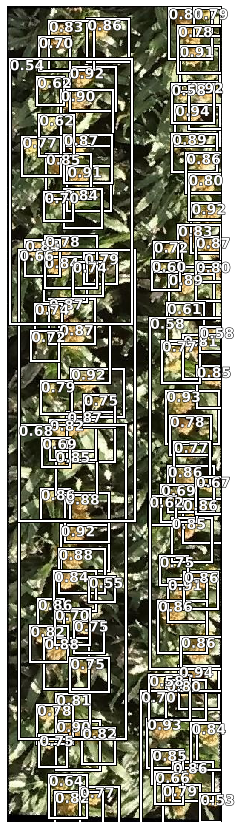

In [22]:
_,axs = plt.subplots(1, 1, figsize=(15,15))

bbox_pred, scores, preds = process_output(z, 0, detect_thresh=0.5)
to_keep = nms(bbox_pred, scores, thresh=0.1)
bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()

t_sz = torch.Tensor([*oimg.size])[None].float()
bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
bbox_pred = bbox_pred.long()
ax=axs
oimg.show(ax=ax)
for bbox, c, scr in zip(bbox_pred, preds, scores):
    txt = str(c.item()) if learn.data.classes is None else learn.data.classes[c.item()+1]
    draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{scr:.2f}')

Unfortunately, these bounding boxes don't seem to be as accurate as the more complicated approach. :(